


**Security and Privacy in Machine Learning**


**HW3**


# **Preface (MUST READ :))**
In this notebook you will firstly train a simple CNN and apply the FGSM attack on it to craft adversarial examples, then you wil launch adversaial training on the same CNN architecture, using your method for crafting adversarial examples. Afterwards you will evaluate the  robustness of the defended CNN against PGD attack and then compare the results of this attack on the defended CNN in different settings.

P.S.1 Reminder that the so-called task might be a little bit time consuming even on CUDA! So make sure to start as soon as you can to meet the excercise deadline properly.

P.S.2 It's suggested to save checkpoints for at least every 10 epochs using Colab GPUs.

P.S.3 Don't forget to add the resnet.py file to the same directory of the current notebook on your PC or on Google Drive (if you want to use the drive)

P.S.4 IMPORTANT: In the answers file you will provide at the end for the questions section, you must present a report including the plots and the required values you are asked for, such as the different accuracy values, the success rates and etc for sections 8, 9, 10, 11, 13, 14, 15, 16. the code of these sections is not enough cause the final report will be checked for the values and plots.


# **Training a ResNet18 model with CIFAR10 Dataset**
Use the cells below to  bulid and train a ResNet18 model on CIFAR10 dataset.

# [1] Initial Setups

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Type
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable
import pickle
import torch.backends.cudnn as cudnn

from torch.utils.data import Dataset, DataLoader

# Please use CUDA :\

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
  print(torch.cuda.get_device_name(0))


!mkdir ./myCIFAR10

from resnet import *

cuda
Tesla T4
mkdir: cannot create directory ‘./myCIFAR10’: File exists


# [2] CIFAR10 Setup

In [4]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = True, download = True, transform = transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/myCIFAR10', train = False, download = True, transform = transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 28302893.25it/s]


Extracting /content/drive/MyDrive/myCIFAR10/cifar-10-python.tar.gz to /content/drive/MyDrive/myCIFAR10
Files already downloaded and verified


# [3] Training Setup

In [5]:
model = ResNet18()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
model.train()

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# [4] Train Phase

In [ ]:
epochs = 101
for epoch in range(epochs):  

    print("epoch " + str(epoch))
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

            
    epoch_loss = running_loss / len(trainset)
    print('Epoch {}/{} - loss: {:.4f}'.format(epoch+1, epochs, epoch_loss))
    
    if epoch % 100 == 0:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, f'/mnt/sda1/users/re_zohrabi/AdvTraining/Checkpoints/std_epoch{epoch}.pth')


print('Finished Training')

epoch 0
Epoch 1/101 - loss: 0.7262
epoch 1
Epoch 2/101 - loss: 0.6122
epoch 2
Epoch 3/101 - loss: 0.5403
epoch 3
Epoch 4/101 - loss: 0.4794
epoch 4
Epoch 5/101 - loss: 0.4356
epoch 5
Epoch 6/101 - loss: 0.3978
epoch 6
Epoch 7/101 - loss: 0.3678
epoch 7
Epoch 8/101 - loss: 0.3445
epoch 8
Epoch 9/101 - loss: 0.3206
epoch 9
Epoch 10/101 - loss: 0.3062
epoch 10
Epoch 11/101 - loss: 0.2777
epoch 11
Epoch 12/101 - loss: 0.2644
epoch 12
Epoch 13/101 - loss: 0.2554
epoch 13
Epoch 14/101 - loss: 0.2416
epoch 14
Epoch 15/101 - loss: 0.2224
epoch 15
Epoch 16/101 - loss: 0.2156
epoch 16
Epoch 17/101 - loss: 0.2012
epoch 17
Epoch 18/101 - loss: 0.1932
epoch 18
Epoch 19/101 - loss: 0.1868
epoch 19
Epoch 20/101 - loss: 0.1747
epoch 20
Epoch 21/101 - loss: 0.1678
epoch 21
Epoch 22/101 - loss: 0.1626
epoch 22
Epoch 23/101 - loss: 0.1560
epoch 23
Epoch 24/101 - loss: 0.1462
epoch 24
Epoch 25/101 - loss: 0.1470
epoch 25
Epoch 26/101 - loss: 0.1341
epoch 26
Epoch 27/101 - loss: 0.1299
epoch 27
Epoch 28/10

# [5] Evaluating Total Standard Accuracy
Check your model accuracy with the following piece of code

In [6]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MSC1401_1/SPML/HW3/HW3_Practical/Checkpoints/std_epoch100.pth')['model_state_dict'])

<All keys matched successfully>

In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Standard Accuracy of ResNet18 model on the 10000 test images: {100 * correct / total} %')

Standard Accuracy of ResNet18 model on the 10000 test images: 92.02 %


# [6] Saving the trained model (Optional)

In [ ]:
model.eval()
CIFAR10_model_PATH = '/content/drive/MyDrive/MSC1401_1/SPML/HW3/HW3_Practical/Checkpoints/Clean/clean_epoch100.pth'
torch.save(model.state_dict(), CIFAR10_model_PATH)

# **Implementing FGSM**

# [7] Fast Gradient Sign Method
You must complete the required sections with proper code for FGSM attack

In the __call__ method, the original code you provided was checking if the predicted label is equal to the true label before generating an adversarial example. While this is a reasonable approach, it may be more effective to generate adversarial examples for all images, regardless of whether they are correctly classified by the model. This can help the model learn to be more robust to adversarial attacks. So I added True condition to it.
Furthermore, the samples that were not successfully attacked may already be close to the decision boundary of the model, which means that they are already relatively difficult for the model to classify correctly. As a result, using these samples in adversarial training may not result in significant improvements in the model's accuracy on other test examples. To address this issue, it may be helpful to use a combination of successfully attacked and non-attacked samples in the adversarial training process, in order to provide the model with a more comprehensive training set that covers a wider range of possible inputs. So I removed the last if too.

In [8]:
class FGSMAttack():

    def __init__(self, model):
        self.model = model
        self.adversarials = []
        self.originals = []
        self.predictions = []
        self.confidences = []
        self.truths = []
        self.perturbations = []


    def untargeted_fgsm(self, image, epsilon, gradient):
      
      # Define untargeted fast gradient sign attack pertubation
      # Firstly perturb the image in the proper direction then clamp it between the right values.
      #############################
      # Your code goes here
      perturbation = epsilon * torch.sign(gradient)
      perturbed_image = image + perturbation
      perturbed_image = torch.clamp(perturbed_image, 0, 1)
      return perturbed_image,perturbation
      #############################

    def __call__(self, image, label, epsilon):
          
      image = image.to(device)
      label = label.to(device)

      true_image = image.clone()    
      image.requires_grad = True

      out = self.model(image)
      _, pred = torch.max(out, 1)

      if True or pred.item() == label.item():

        # Now define a loss(use the negative log likelihood loss),
        # Zero the gradients of the model parameters and do the backpropagation
        # Retrieve the gradient of the loss with respect to the input image
        # Finally use the function you defined earlier to craft the perturbed image
        #############################
        # Your code goes here
        loss = F.nll_loss(out, label)
        self.model.zero_grad()
        loss.backward()
        gradient = image.grad.data
        perturbed_image, perturbation = self.untargeted_fgsm(image, epsilon, gradient)
        #############################

        out2 = self.model(perturbed_image)

        _, pred2 = torch.max(out2.data, 1)

        confidence = F.softmax(out2, dim=1)[0][pred2].data.cpu().numpy()[0]
        
        prob = confidence

        self.adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
        self.originals.append(true_image.squeeze().detach().cpu().numpy())
        self.predictions.append(pred2.item())
        self.confidences.append(confidence.item())
        self.truths.append(label.item())

        return self.adversarials, self.originals, self.predictions, self.confidences, self.truths


# [8] Evaluating FGSM Accuracy of Standard Trained Model

In [9]:
def fgsm_batch_attack(model, images, labels, epsilon):
    attack = FGSMAttack(model)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(len(images)):
        attack(images[i].unsqueeze(0), labels[i].unsqueeze(0), epsilon)
    return torch.tensor(attack.adversarials),torch.tensor(attack.originals),torch.tensor(attack.predictions),torch.tensor(attack.confidences),torch.tensor(attack.truths)

In [11]:
# For 3 values of epsilon = 4/255, 8/255, 12/255
# Launch the FGSM attack,
# Use the whole testloader to generate a set of adversarial examples on the CIFAR10 testset
# Then use this new testset for calculating the adversarial accuracy of the standard target model
#############################
# Your code goes here

model.eval()
epsilon_list = [4/255, 8/255, 12/255]
adv_test_sets = {_: [] for _ in epsilon_list}
org_test_sets = {_: [] for _ in epsilon_list}
adv_preds = {_: [] for _ in epsilon_list}
adv_confs = {_: [] for _ in epsilon_list}
true_labels = {_: [] for _ in epsilon_list}


for i, epsilon in enumerate(epsilon_list):

    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        adversarials, originals, preds, confs, labels = fgsm_batch_attack(model, images, labels, epsilon)
        adv_test_sets[epsilon].extend(adversarials)
        org_test_sets[epsilon].extend(originals)
        adv_preds[epsilon].extend(preds)
        adv_confs[epsilon].extend(confs)
        true_labels[epsilon].extend(labels)

        
class AdversarialTestset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

adv_test_loaders = {_: [] for _ in epsilon_list}
for eps,adv_test_set in adv_test_sets.items():
    dataset = AdversarialTestset(adv_test_set,true_labels[eps])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    adv_test_loaders[eps].extend(dataloader)

with torch.no_grad():
    for eps,adv_loader in adv_test_loaders.items():
        correct = 0
        total = 0
        for data in adv_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Adversarial accuracy epsilon {eps} : {100 * correct / total}")
#############################

<ipython-input-9-131437cd2dec>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(attack.adversarials),torch.tensor(attack.originals),torch.tensor(attack.predictions),torch.tensor(attack.confidences),torch.tensor(attack.truths)


Adversarial accuracy epsilon 0.01568627450980392 : 51.63
Adversarial accuracy epsilon 0.03137254901960784 : 47.42
Adversarial accuracy epsilon 0.047058823529411764 : 43.58


# [9] Crafting Adversarial Examples with FGSM

In [13]:
# Using the epsilon value of 8/255
# For the first 5 adversarial images, 
# Print the true label, the model prediction and the confidence of each prediction for each image
#############################
# Your code goes here


epsilon = 8/255
ploting_images = []
ploting_lbls = []
adv_images,orgs, true_lbls,preds,confs = adv_test_sets[epsilon][:10], org_test_sets[epsilon][:10], true_labels[epsilon][:10], adv_preds[epsilon][:10], adv_confs[epsilon][:10]

c = 0
for i, true_lbl in enumerate(true_lbls):

    if true_lbl != preds[i] and c < 5 :
        c += 1
        ploting_images.append(orgs[i])
        ploting_lbls.append(true_lbl)
        print(f"Image {i+1}")
        print(f"True Label: {classes[true_lbls[i].item()]}")
        print(f"Model Prediction: {classes[preds[i].item()]}")
        print(f"Confidence: {confs[i].item():.2f}%\n")
#############################

Image 3
True Label: ship
Model Prediction: plane
Confidence: 0.63%

Image 6
True Label: frog
Model Prediction: ship
Confidence: 0.44%

Image 7
True Label: car
Model Prediction: ship
Confidence: 0.39%

Image 8
True Label: frog
Model Prediction: bird
Confidence: 0.88%

Image 9
True Label: cat
Model Prediction: dog
Confidence: 0.74%



# [10] Plotting


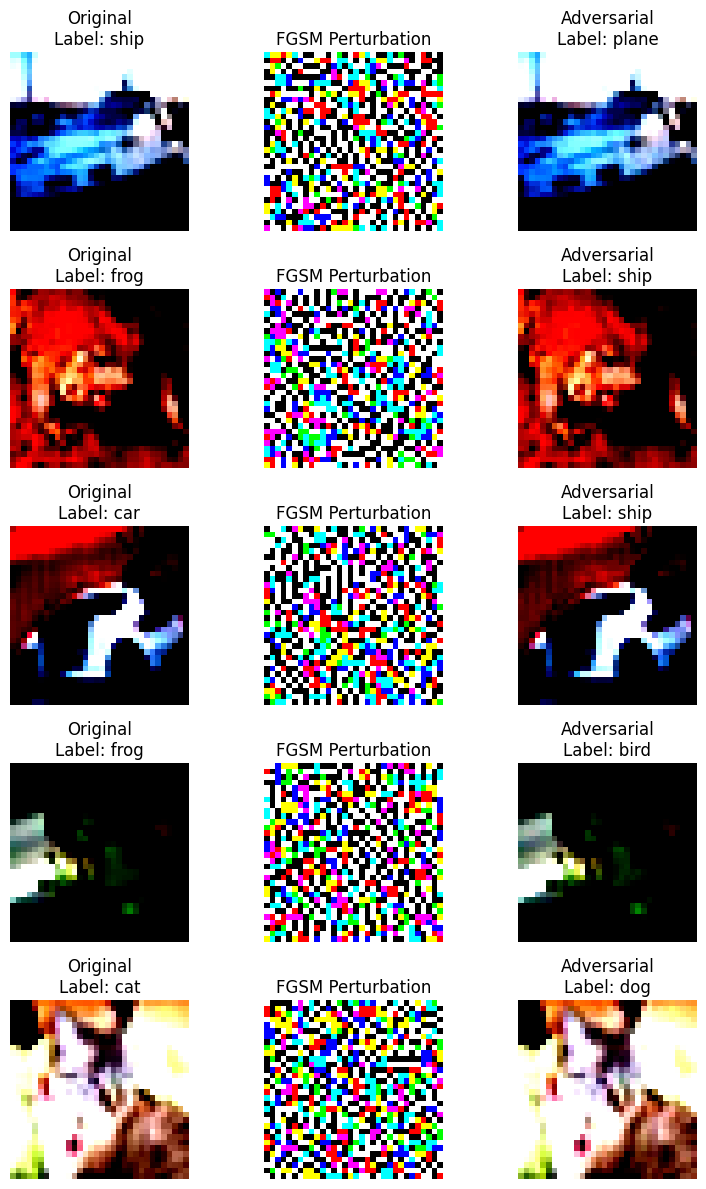

In [14]:
import matplotlib.pyplot as plt
# Now show the 5 original test images mentioned in the previous cell
# And the FGSM perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned FGSM perturbation
#############################
# Your code goes here

epsilon = 8/255

fig, axs = plt.subplots(5, 3, figsize=(8, 12))
c =0
for i, true_lbl in enumerate(true_lbls):
    
    if true_lbl != preds[i]:
        
        image = orgs[i]
        
        # Show original test image
        axs[c][0].imshow(image.permute(1, 2, 0))
        axs[c][0].set_title(f"Original\nLabel: {classes[true_lbl]}")
        axs[c][0].axis('off')

        # Add FGSM perturbation to image
        image = image.unsqueeze(0).to(device)
        image.requires_grad = True
        adversarial = adv_images[i]
        output = model(image)
        loss = criterion(output, true_lbl.unsqueeze(0).to(device))
        gradient = torch.autograd.grad(loss, image)[0]
        perturbation = 100 * epsilon * torch.sign(gradient)

        # Show FGSM perturbation
        axs[c][1].imshow(perturbation.squeeze(0).cpu().permute(1, 2, 0))
        axs[c][1].set_title(f"FGSM Perturbation")
        axs[c][1].axis('off')

        # Show adversarial example
        axs[c][2].imshow(adversarial.squeeze(0).cpu().permute(1, 2, 0))
        axs[c][2].set_title(f"Adversarial\nLabel: {classes[preds[i]]}")
        axs[c][2].axis('off')
        c+=1
plt.tight_layout()
plt.show()
#############################

# [11] **Adversarial Training**

In [15]:
num_epochs = 101
model_adv = ResNet18().to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(model_adv.parameters(), lr=learning_rate,momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_adv, milestones=[int(0.5*num_epochs), int(0.75*num_epochs)], gamma=0.1)


In [ ]:
# Now train a ResNet model with FGSM adversarial examples crafted on CIFAR10 trainset
# Then report the clean accuracy of this adversarially trained network on the clean CIFAR10 testset
# Also report the adversarial accuracy of this adversarially trained network against FGSM with epsilon = 8/255 on the CIFAR10 testset
# Try using a scheduler for the learning rate (if needed)
#############################
# Your code goes here

for epoch in range(num_epochs):
    model_adv.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        model_adv.eval()
        adv_inputs,_,_,_,_ = fgsm_batch_attack(model_adv,inputs, targets, epsilon=8/255)
        model_adv.train()
        
        optimizer_adv.zero_grad()
        outputs = model_adv(adv_inputs.to(device))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('Epoch: %d | Batch: %d/%d | Loss: %.3f | Acc: %.3f%%'
                  % (epoch+1, batch_idx+1, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total))
            
    scheduler.step()

    if epoch % 100 == 0:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model_adv.state_dict(),
            'optimizer_state_dict': optimizer_adv.state_dict(),
            }, f'/content/drive/MyDrive/MSC1401_1/SPML/HW3/HW3_Practical/Checkpoints/adv_epoch{epoch}.pth')
     
#############################

Epoch: 1 | Batch: 1/391 | Loss: 2.367 | Acc: 10.938%
Epoch: 1 | Batch: 101/391 | Loss: 1.917 | Acc: 29.015%
Epoch: 1 | Batch: 201/391 | Loss: 1.799 | Acc: 33.769%
Epoch: 1 | Batch: 301/391 | Loss: 1.719 | Acc: 36.849%
Epoch: 2 | Batch: 1/391 | Loss: 1.460 | Acc: 48.438%
Epoch: 2 | Batch: 101/391 | Loss: 1.422 | Acc: 48.940%
Epoch: 2 | Batch: 201/391 | Loss: 1.391 | Acc: 50.163%
Epoch: 2 | Batch: 301/391 | Loss: 1.363 | Acc: 51.311%
Epoch: 3 | Batch: 1/391 | Loss: 1.132 | Acc: 59.375%
Epoch: 3 | Batch: 101/391 | Loss: 1.206 | Acc: 57.201%
Epoch: 3 | Batch: 201/391 | Loss: 1.185 | Acc: 58.186%
Epoch: 3 | Batch: 301/391 | Loss: 1.172 | Acc: 58.459%
Epoch: 4 | Batch: 1/391 | Loss: 1.047 | Acc: 57.812%
Epoch: 4 | Batch: 101/391 | Loss: 1.060 | Acc: 62.554%
Epoch: 4 | Batch: 201/391 | Loss: 1.039 | Acc: 63.262%
Epoch: 4 | Batch: 301/391 | Loss: 1.035 | Acc: 63.588%
Epoch: 5 | Batch: 1/391 | Loss: 0.885 | Acc: 71.875%
Epoch: 5 | Batch: 101/391 | Loss: 0.923 | Acc: 67.683%
Epoch: 5 | Batch: 20

Epoch: 38 | Batch: 101/391 | Loss: 0.248 | Acc: 91.228%
Epoch: 38 | Batch: 201/391 | Loss: 0.251 | Acc: 91.134%
Epoch: 38 | Batch: 301/391 | Loss: 0.255 | Acc: 91.027%
Epoch: 39 | Batch: 1/391 | Loss: 0.351 | Acc: 87.500%
Epoch: 39 | Batch: 101/391 | Loss: 0.235 | Acc: 91.801%
Epoch: 39 | Batch: 201/391 | Loss: 0.241 | Acc: 91.496%
Epoch: 39 | Batch: 301/391 | Loss: 0.253 | Acc: 90.994%
Epoch: 40 | Batch: 1/391 | Loss: 0.193 | Acc: 92.969%
Epoch: 40 | Batch: 101/391 | Loss: 0.226 | Acc: 92.048%
Epoch: 40 | Batch: 201/391 | Loss: 0.233 | Acc: 91.741%
Epoch: 40 | Batch: 301/391 | Loss: 0.240 | Acc: 91.494%
Epoch: 41 | Batch: 1/391 | Loss: 0.188 | Acc: 94.531%
Epoch: 41 | Batch: 101/391 | Loss: 0.230 | Acc: 92.172%
Epoch: 41 | Batch: 201/391 | Loss: 0.234 | Acc: 91.764%
Epoch: 41 | Batch: 301/391 | Loss: 0.233 | Acc: 91.749%
Epoch: 42 | Batch: 1/391 | Loss: 0.188 | Acc: 92.969%
Epoch: 42 | Batch: 101/391 | Loss: 0.211 | Acc: 92.628%
Epoch: 42 | Batch: 201/391 | Loss: 0.223 | Acc: 92.176%


KeyboardInterrupt: 

In [ ]:
torch.save({
            'epoch': 66,
            'model_state_dict': model_adv.state_dict(),
            'optimizer_state_dict': optimizer_adv.state_dict(),
            }, f'/content/drive/MyDrive/MSC1401_1/SPML/HW3/HW3_Practical/Checkpoints/adv_epoch{66}.pth')



In [16]:
model_adv.load_state_dict(torch.load('/content/drive/MyDrive/MSC1401_1/SPML/HW3/HW3_Practical/Checkpoints/adv_epoch66.pth')['model_state_dict'])

<All keys matched successfully>

In [17]:
#This is the evaluation of the model traiend for 66 epoch
model_adv.eval()


total = 0
correct_adv =0
correct = 0

for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    adversarials, originals, preds, confs, labels = fgsm_batch_attack(model_adv, images, labels, 8/255)
    outputs = model_adv(originals.to(device))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()
    correct_adv += (preds.to(device) == labels.to(device)).sum().item()

print(f"Adversarial accuracy epsilon {8/255} : {100 * correct_adv / total}")
print(f"Standard accuracy epsilon {8/255} : {100 * correct / total}")        

adv_dataset = AdversarialTestset(adv_test_sets,true_labels)
adv_dataloader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Adversarial accuracy epsilon 0.03137254901960784 : 85.38
Standard accuracy epsilon 0.03137254901960784 : 10.75


In [ ]:
#This is the evaluation of model trained for 20 epoch
model_adv.eval()


total = 0
correct_adv =0
correct = 0

for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    adversarials, originals, preds, confs, labels = fgsm_batch_attack(model_adv, images, labels, 8/255)
    outputs = model_adv(originals.to(device))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()
    correct_adv += (preds.to(device) == labels.to(device)).sum().item()

print(f"Adversarial accuracy epsilon {8/255} : {100 * correct_adv / total}")
print(f"Standard accuracy epsilon {8/255} : {100 * correct / total}")        

adv_dataset = AdversarialTestset(adv_test_sets,true_labels)
adv_dataloader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Adversarial accuracy epsilon 0.03137254901960784 : 76.69
Standard accuracy epsilon 0.03137254901960784 : 16.42


# **Implementing PGD**

# [12] Projected Gradient Descent
You must complete the required sections with proper code for PGD attack

In [20]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):

      out = self.model(image)
      _, pred = torch.max(out.data, 1)


      perturbed_image = image.clone()

      # Now use the input information of the class to implement a k step PGD attack
      # of size alpha while always staying within epsilon distance from the initial point
      # Use cross entropy loss
      #############################
      # Your code goes here

      for i in range(self.steps):
                perturbation = torch.zeros_like(image)
                perturbed_image.requires_grad = True
                out = self.model(perturbed_image)
                loss = F.cross_entropy(out, label)
                self.model.zero_grad()
                loss.backward()
                with torch.no_grad():
                    pert = self.alpha * perturbed_image.grad.sign()
                    perturbation += pert
                    perturbed_image = torch.clamp(image + perturbation, 0, 1)
                    perturbed_image = torch.max(torch.min(perturbed_image, image + self.epsilon), image - self.epsilon)
      return perturbed_image.detach(), perturbation.detach()

          ############################# 


# [13] Evaluating PGD Accuracy of Adversarially Trained Model and Standard Trained Model

In [ ]:
# Now launch the attack with the proper inputs for the whole CIFAR10 testset (with epsilon = 8/255)
# on the adversarially trained model and the standard trained model with 2 different step settings: k = 2 and k = 4
# Then print the PGD Accuracy for the images crafted with these 2 settings on the defended model and the standard model

# By PGD Accuracy we mean check if the adversarially trained model could still understand the true label that must be predicted
# Or will the model still get fooled by the PGD attack again after the FGSM adversarial training?
#############################

# Your code goes here
epsilon = 8/255
k_values = [2, 4]
alpha = 2/255


def pgd_evaluate(model, attack):
    model.eval()
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = []
        for i in range(images.size(0)):
            perturbed_image,_ = attack(images[i].unsqueeze(0), labels[i].unsqueeze(0))

            perturbed_images.append(perturbed_image)
        
        perturbed_images = torch.cat(perturbed_images, dim=0)

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

pgd_attacks = {}
for k in k_values:
    pgd_attacks[k] = LinfPGDAttack(model, epsilon, k, alpha)

print("Standard Trained Model:")
standard_accuracy_k2 = pgd_evaluate(model, pgd_attacks[2])
print(f"PGD Accuracy (k=2): {standard_accuracy_k2:.2f}%")
standard_accuracy_k4 = pgd_evaluate(model, pgd_attacks[4])
print(f"PGD Accuracy (k=4): {standard_accuracy_k4:.2f}%")

pgd_attacks = {}
for k in k_values:
    pgd_attacks[k] = LinfPGDAttack(model_adv, epsilon, k, alpha)

print("\nAdversarially Trained Model:")
defense_accuracy_k2 = pgd_evaluate(model_adv, pgd_attacks[2])
print(f"PGD Accuracy (k=2): {defense_accuracy_k2:.2f}%")
defense_accuracy_k4 = pgd_evaluate(model_adv, pgd_attacks[4])
print(f"PGD Accuracy (k=4): {defense_accuracy_k4:.2f}%")
############################# 

# [14] Plotting

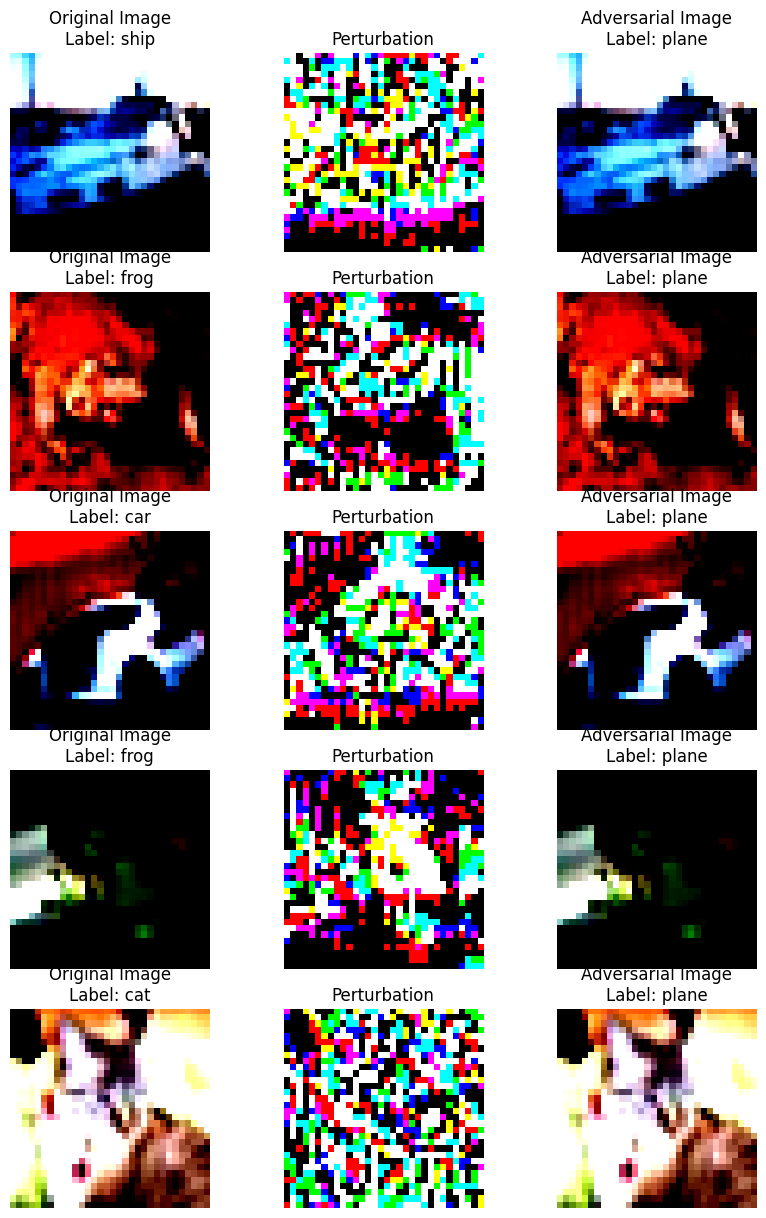

In [27]:
# Now show 5 original test images from the CIFAR10 testset 
# And the PGD perturbation added to each image (with epsilon = 8/255)
# Then the adversarial example created on the same 5 test images using the mentioned PGD perturbation
#############################
# Your code goes here

pgd_attack = LinfPGDAttack(model_adv, epsilon=8/255, k=4, alpha=2/255)

fig, axs = plt.subplots(5, 3, figsize=(10, 15))

for i in range(5):

    image = ploting_images[i].unsqueeze(0)
    label = ploting_lbls[i]
    perturbed_image, perturbation = pgd_attack(image.to(device), label.to(device).unsqueeze(0))
    outputs = model_adv(perturbed_image)
    _, predicted = torch.max(outputs.data, 1)

    axs[i, 0].imshow(image.squeeze().permute(1, 2, 0))
    axs[i, 0].set_title(f"Original Image\nLabel: {classes[label.item()]}")
    axs[i, 0].axis('off')
    axs[i, 1].imshow(1000*perturbation.squeeze().cpu().permute(1, 2, 0))
    axs[i, 1].set_title('Perturbation')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(perturbed_image.squeeze().cpu().permute(1, 2, 0))
    axs[i, 2].set_title(f"Adversarial Image\nLabel: {classes[predicted.item()]}")
    axs[i, 2].axis('off')
    
plt.show()
#############################

# [15] Noisy Input Accuracy

In [25]:
# Add Gaussian noise with mean of 0 and variance of 6/255 to the CIFAR10 testset
# Evaluate the accuracy of these noisy images on the standard trained model and the adversarially trained model
# What do you conclude from the results of applying noisy inputs and adversarial example inputs to both of the models?
#############################
# Your code goes here

testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)


model.eval()
model_adv.eval()

mean = 0
variance = (6/255)**2
gaussian_noise = np.random.normal(mean, variance, size=(len(testset), 3, 32, 32))
gaussian_noise = torch.tensor(gaussian_noise, dtype=torch.float32)

total = 0
correct_std = 0
correct_adv = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        noisy_images = images + gaussian_noise[i]
        noisy_images = torch.clamp(noisy_images, 0, 1)
        images, labels, noisy_images = images.to(device), labels.to(device), noisy_images.to(device)
        outputs_std = model(images)
        _, predicted_std = torch.max(outputs_std.data, 1)
        outputs_adv = model_adv(noisy_images)
        _, predicted_adv = torch.max(outputs_adv.data, 1)
        total += labels.size(0)
        correct_std += (predicted_std == labels).sum().item()
        correct_adv += (predicted_adv == labels).sum().item()

print('Accuracy of the standard model on noisy images: {:.2f}%'.format(100 * correct_std / total))
print('Accuracy of the adversarial model on noisy images: {:.2f}%'.format(100 * correct_adv / total))

#############################

Accuracy of the standard model on noisy images: 92.02%
Accuracy of the adversarial model on noisy images: 85.46%


# [16] Logit VS Epsilon Test

Predicted label: dog, True label: dog


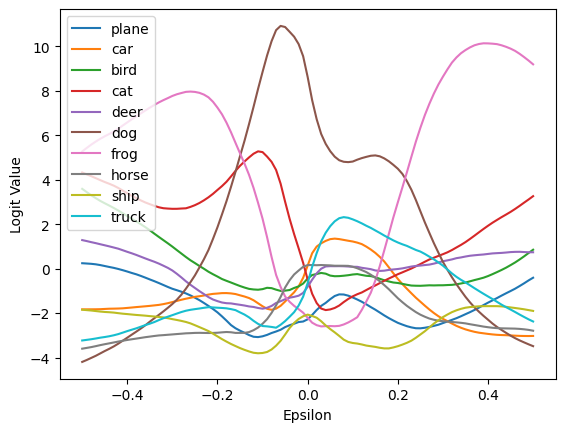

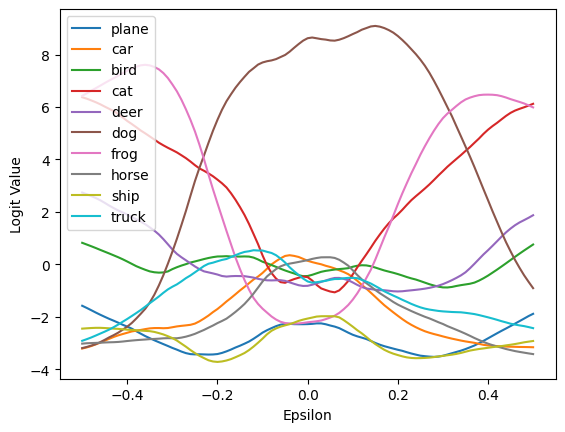

In [71]:
# Pick the first image x from the CIFAR10 testset
# Make sure the prediction for this image is done correctly by the standard trained model
# Compute the gradient of the model's loss with respect to the image x
# Now for the epsilon values between -0.5 and 0.5 with step size of 0.01 (101 different values),
# Compute x + \epsilon.sign(\nabla_x J(W, x, y))
# Get the logit value for these 101 different images (by logit we mean the softmax input)
# Then plot the logit value vs the epsilon value diagram
# Now choose a random direction instead of \nabla_x J(W, x, y), from the Uniform basis between -1 and 1 for each dimension
# Plot the logit value vs the epsilon value diagram with respect to the new direction
# What is your conclusion based on the results achieved from the two digrams?
#############################
# Your code goes here

images, labels = next(iter(testloader))
image = images[0].unsqueeze(0).to(device)  

outputs = model(image)
_, predicted = torch.max(outputs.data, 1)
print(f"Predicted label: {classes[predicted.item()]}, True label: {classes[labels[0].item()]}")

image.requires_grad = True
outputs = model(image)
loss = torch.nn.functional.cross_entropy(outputs, labels.to(device))
loss.backward()
grad = image.grad.detach()

epsilon_values = torch.linspace(-0.5, 0.5, steps=101)
logits = []
for epsilon in epsilon_values:
    perturbed_image = image + epsilon * torch.sign(grad)
    perturbed_outputs = model(perturbed_image)
    logits.append(perturbed_outputs.detach().cpu().squeeze().numpy())

plt.plot(epsilon_values, logits, label=classes)
plt.xlabel('Epsilon')
plt.ylabel('Logit Value')
plt.legend(loc='upper left')
plt.show()

direction = torch.randn_like(image)

logits = []
for epsilon in epsilon_values:
    perturbed_image = image + epsilon * torch.sign(direction)
    perturbed_outputs = model(perturbed_image)
    logits.append(perturbed_outputs.detach().cpu().squeeze().numpy())

plt.plot(epsilon_values, logits, label=classes)
plt.xlabel('Epsilon')
plt.ylabel('Logit Value')
plt.legend(loc='upper left')
plt.show()

#############################